<a href="https://colab.research.google.com/github/JohnTichenor/Locating-Bacterial-Flagellar-Motors/blob/main/Faster_RCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 108.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 88.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 40.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 108.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvji

## Import Dependencies

In [2]:
import torch
from torch.utils.data import DataLoader
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torchvision.transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

## Mount Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load Data

In [4]:
TRAIN_DIR = "/content/drive/MyDrive/BacterialFlagellarMotorsData/train"
TEST_DIR = "/content/drive/MyDrive/BacterialFlagellarMotorsData/test"
LABELS_PATH = "/content/drive/MyDrive/BacterialFlagellarMotorsData/train_labels.csv"
SUBMIT_PATH = "/content/drive/MyDrive/BacterialFlagellarMotorsData/submission.csv"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Create Bounding Boxes

In [5]:
import pandas as pd
import json
import os

def create_motor_bounding_boxes(csv_path, output_json_path, box_size=32):
    """
    Convert 3D motor coordinates into 2D bounding boxes and save as JSON.

    Args:
        csv_path (str): Path to the CSV file with motor annotations.
        output_json_path (str): Path to save the output JSON file.
        box_size (int): Width/height of the bounding box (in pixels). Default is 32.

    Returns:
        str: Path to the saved JSON file.
    """

    if os.path.exists(output_json_path):
        print(f"⚠️ JSON already exists at '{output_json_path}'. Skipping creation.")
        return output_json_path

    df = pd.read_csv(csv_path)
    half = box_size // 2
    bbox_dict = {}

    for _, row in df.iterrows():
        z = row["Motor axis 0"]
        y = row["Motor axis 1"]
        x = row["Motor axis 2"]
        tomo_id = row["tomo_id"]

        # Skip entries with invalid motor position
        if z < 0 or x < 0 or y < 0:
            continue

        # Construct the image filename (e.g. tomo_00e047/slice_0169.jpg)
        image_filename = f"{tomo_id}/slice_{int(z):04d}.jpg"

        # Compute bounding box coordinates centered at (x, y)
        xmin = max(0, int(x - half))
        ymin = max(0, int(y - half))
        xmax = int(x + half)
        ymax = int(y + half)

        # Append annotation
        bbox = [xmin, ymin, xmax, ymax]
        label = 1  # Only one class: motor

        if image_filename not in bbox_dict:
            bbox_dict[image_filename] = []

        bbox_dict[image_filename].append({"bbox": bbox, "label": label})

    # Write to JSON
    with open(output_json_path, "w") as f:
        json.dump(bbox_dict, f, indent=2)

    return output_json_path


# Bounding Box Output Path "bounding_boxes_<box_size>.json"
bounding_boxes_json = "/content/drive/MyDrive/BacterialFlagellarMotorsData/bounding_boxes_32.json"

create_motor_bounding_boxes(LABELS_PATH, bounding_boxes_json, box_size=32)

⚠️ JSON already exists at '/content/drive/MyDrive/BacterialFlagellarMotorsData/bounding_boxes_32.json'. Skipping creation.


'/content/drive/MyDrive/BacterialFlagellarMotorsData/bounding_boxes_32.json'

## Draw Boxes

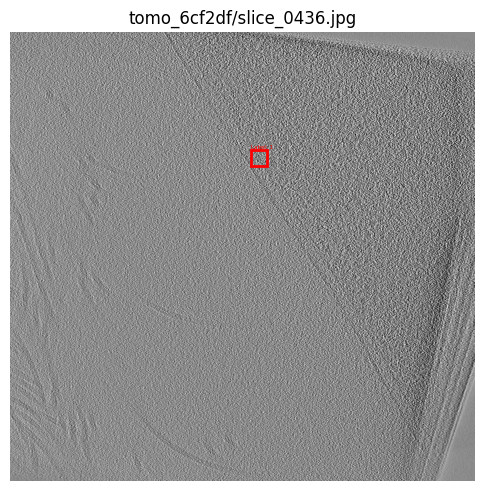

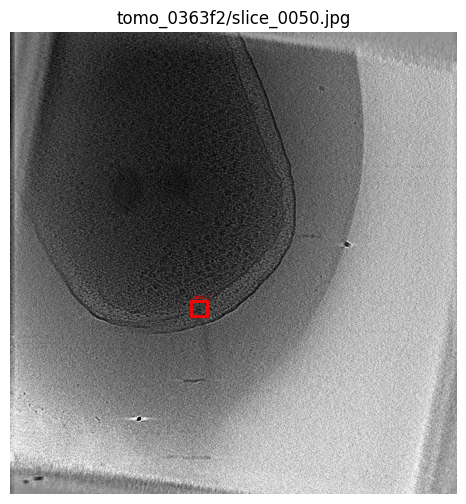

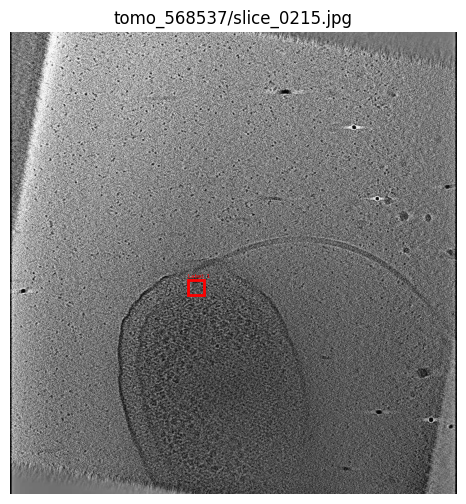

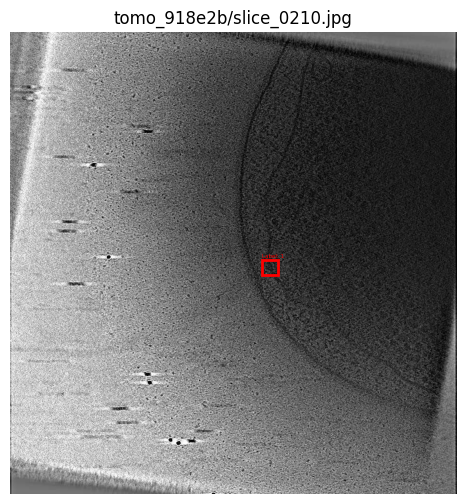

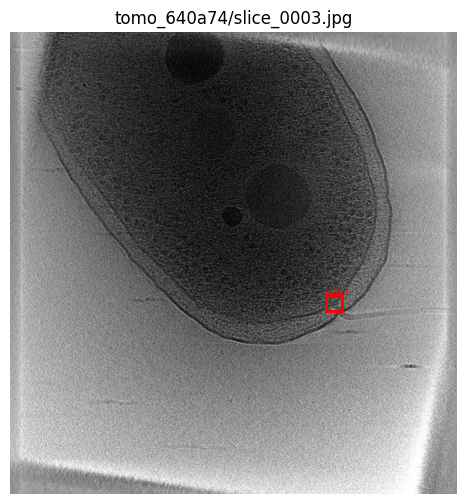

In [6]:
import json
import random
import os
import matplotlib.pyplot as plt
from PIL import Image

def visualize_bounding_boxes(json_path, root_dir, n=5):
    """
    Visualize bounding boxes from JSON on randomly selected image slices.

    Args:
        json_path (str): Path to the JSON file containing bounding boxes.
        root_dir (str): Root directory containing image folders (e.g., tomo_id/slice_xxxx.jpg).
        n (int): Number of images to visualize.
    """
    # Load the bounding box annotations
    with open(json_path, "r") as f:
        bbox_dict = json.load(f)

    # Select random N image filenames
    image_files = random.sample(list(bbox_dict.keys()), min(n, len(bbox_dict)))

    for img_rel_path in image_files:
        img_path = os.path.join(root_dir, img_rel_path)
        if not os.path.exists(img_path):
            print(f"Image not found: {img_path}")
            continue

        img = Image.open(img_path).convert("RGB")

        # Plot the image
        plt.figure(figsize=(6, 6))
        plt.imshow(img)
        ax = plt.gca()

        # Draw bounding boxes
        for ann in bbox_dict[img_rel_path]:
            xmin, ymin, xmax, ymax = ann["bbox"]
            rect = plt.Rectangle(
                (xmin, ymin), xmax - xmin, ymax - ymin,
                linewidth=2, edgecolor='red', facecolor='none'
            )
            ax.add_patch(rect)
            ax.text(xmin, ymin - 5, f"Label: {ann['label']}", color='red', fontsize=4)

        plt.title(img_rel_path)
        plt.axis("off")
        plt.show()

visualize_bounding_boxes(
    json_path=bounding_boxes_json,
    root_dir=TRAIN_DIR,
    n=5  # View 5 images
)


# Format the Dataset

In [7]:
from torch.utils.data import Dataset
from PIL import Image

class TomogramDataset(Dataset):
    def __init__(self, root_dir, json_path, transforms=None):
        """
        root_dir: path to the folder containing tomogram subfolders
        json_path: bounding box annotations (from motor_bounding_boxes.json)
        """
        self.root_dir = root_dir
        self.transforms = transforms

        with open(json_path) as f:
            self.annotations = json.load(f)

        self.image_paths = list(self.annotations.keys())  # e.g., tomo_00e047/slice_0169.jpg

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        rel_path = self.image_paths[idx]
        img_path = os.path.join(self.root_dir, rel_path)

        image = Image.open(img_path).convert("RGB")

        boxes = torch.tensor([ann["bbox"] for ann in self.annotations[rel_path]], dtype=torch.float32)
        labels = torch.tensor([ann["label"] for ann in self.annotations[rel_path]], dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": torch.tensor([idx]),
            "area": (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1]),
            "iscrowd": torch.zeros((len(boxes),), dtype=torch.int64)
        }

        if self.transforms:
            image = self.transforms(image)

        return image, target

In [8]:
from torchvision import transforms

# Your custom dataset
dataset = TomogramDataset(
    root_dir=TRAIN_DIR,
    json_path=bounding_boxes_json,
    transforms=transforms.ToTensor()
)

# Dataloader
data_loader = DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

### Define the Model

In [12]:
# Load a pre-trained Faster R-CNN
model = fasterrcnn_resnet50_fpn(pretrained=True)

# Replace the classification head
num_classes = 2  # 1 motor class + 1 background
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Put model on GPU
model.to(device)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

# Main

In [13]:
!pip install tqdm

In [ ]:
from tqdm import tqdm

# Some HP
num_epochs = 10
lr = 0.005

# Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=0.0005)

# Training Loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    pbar = tqdm(data_loader, desc=f"Epoch {epoch + 1}/{num_epochs}", leave=False)

    for images, targets in pbar:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        total_loss += losses.item()

    print(f"[Epoch {epoch + 1}/{num_epochs}] Loss: {total_loss:.4f}")



Epoch 1/10:  23%|██▎       | 26/113 [02:21<07:10,  4.95s/it]